<a href="https://colab.research.google.com/github/silviaherf/foodie_api/blob/main/src/Inception_V6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train and serve a TensorFlow model with TensorFlow Serving

**Warning: This notebook is designed to be run in a Google Colab only**.  It installs packages on the system and requires root access.  If you want to run it in a local Jupyter notebook, please proceed with caution.

Note: You can run this example right now in a Jupyter-style notebook, no setup required!  Just click "Run in Google Colab"

<div class="devsite-table-wrapper"><table class="tfo-notebook-buttons" align="left">
<tr><td><a target="_blank" href="https://www.tensorflow.org/tfx/tutorials/serving/rest_simple">
<img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a></td>
<td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
<td><a target="_blank" href="https://github.com/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
</tr></table></div>

This guide trains a neural network model to classify [images of clothing, like sneakers and shirts](https://github.com/zalandoresearch/fashion-mnist), saves the trained model, and then serves it with [TensorFlow Serving](https://www.tensorflow.org/serving/).  The focus is on TensorFlow Serving, rather than the modeling and training in TensorFlow, so for a complete example which focuses on the modeling and training see the [Basic Classification example](https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/keras/basic_classification.ipynb).

This guide uses [tf.keras](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/keras.ipynb), a high-level API to build and train models in TensorFlow.

In [ ]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major is 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [ ]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0


Installing dependencies for Colab environment


In [ ]:
import cv2
import glob
import os
import random
import pandas as pd
import seaborn as sns
from google.colab import files
from shutil import copy
from shutil import copytree, rmtree
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.losses import categorical_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam,Adadelta,SGD
from tensorflow.keras.backend import mean
from tensorflow.keras.losses import mse
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler 
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from zipfile import ZipFile 
from sklearn.metrics import confusion_matrix

print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.3.0


## Create your model

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_name = '/content/drive/My Drive/foodie API/food.zip'

In [ ]:
names=[
 'tacos',
 'pizza',
 'hamburger',
 'spaghetti_bolognese',
 'sushi'
]

In [ ]:
from zipfile import ZipFile 

archive = ZipFile(file_name)

for file in archive.namelist():
  
  if file.split('/')[1] in names:
      archive.extract(file)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        zoom_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(256,256),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb')

Found 3750 images belonging to 5 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(256,256),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb')

Found 1250 images belonging to 5 classes.


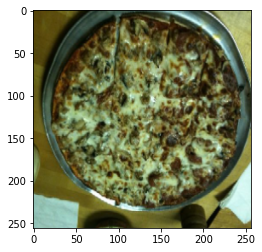

In [ ]:
i=random.randint(0,47)
plt.imshow(train_generator[i][0][0])

We define our net topology


In [ ]:
test_generator.class_indices

{'hamburger': 0, 'pizza': 1, 'spaghetti_bolognese': 2, 'sushi': 3, 'tacos': 4}

In [ ]:
epocas=14
n_classes=len(train_generator.class_indices)
#opt = tf.keras.optimizers.Adam(learning_rate=0.1)
#optimizer = tf.train.AdamOptimizer(0.001)
opt = SGD(lr=1e-2, momentum=0.9, decay=1e-2 / epocas)
loss="categorical_crossentropy"
#optimizers=[Adam(),Adadelta(),SGD(learning_rate=1)]

In [ ]:
inception=InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling=None,
    classes=n_classes,
    classifier_activation="softmax",
)


In [ ]:
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.7)(x)

In [ ]:
predictions = Dense(n_classes,kernel_regularizer=l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)

In [ ]:
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
!mkdir ../content/models

mkdir: cannot create directory ‘../content/models’: File exists


In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

checkpointer = ModelCheckpoint(filepath='../content/models/InceptionV6_check.hdf5', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=epocas,
                    verbose=1,
                    callbacks=[earlystopping,checkpointer])



Epoch 1/14
47/47 [==============================] - ETA: 0s - loss: 0.9594 - accuracy: 0.6443
Epoch 00001: val_loss improved from inf to 0.83313, saving model to ../content/models/InceptionV6_check.hdf5
47/47 [==============================] - 85s 2s/step - loss: 0.9594 - accuracy: 0.6443 - val_loss: 0.8331 - val_accuracy: 0.7312
Epoch 2/14
47/47 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.8741
Epoch 00002: val_loss did not improve from 0.83313
47/47 [==============================] - 83s 2s/step - loss: 0.4509 - accuracy: 0.8741 - val_loss: 1.9844 - val_accuracy: 0.5752
Epoch 3/14
47/47 [==============================] - ETA: 0s - loss: 0.3106 - accuracy: 0.9152
Epoch 00003: val_loss improved from 0.83313 to 0.76644, saving model to ../content/models/InceptionV6_check.hdf5
47/47 [==============================] - 84s 2s/step - loss: 0.3106 - accuracy: 0.9152 - val_loss: 0.7664 - val_accuracy: 0.7696
Epoch 4/14
47/47 [==============================] - ETA: 0

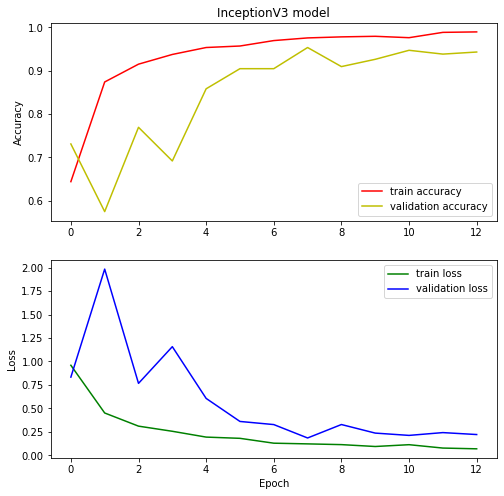

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.title('InceptionV3 model')
plt.plot(history.history['accuracy'],'r')
plt.ylabel('Accuracy')
plt.plot(history.history['val_accuracy'],'y')
plt.legend(['train accuracy','validation accuracy'], loc='best')



plt.subplot(2,1,2)
plt.plot(history.history['loss'],'g')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history.history['val_loss'],'b')
plt.legend(['train loss','validation loss'], loc='best')


plt.savefig('../content/models/InceptionV6_5.png')

In [ ]:
model.save('../content/models/InceptionV6_model.hdf5')

In [ ]:
files.download('../content/models/InceptionV6_5.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('../content/models/InceptionV6_check.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('../content/models/InceptionV6_model.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_pred=model.predict(test_generator[0][0])
for i in range(1,len(test_generator)):  
  pred=model.predict(test_generator[i][0])
  y_pred=np.concatenate((y_pred,pred),axis=0)

In [ ]:
len(y_pred)

1250

In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
gt = np.argmax(test_generator[0][1], axis=1)
for i in range(1,len(test_generator)):  
  gt=np.concatenate((gt,np.argmax(test_generator[i][1],axis=1)),axis=0)

In [ ]:
gt

array([3, 4, 3, ..., 3, 3, 2])

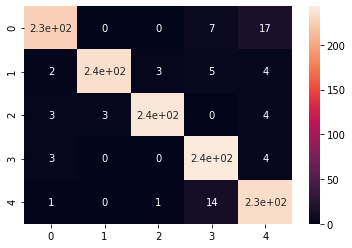

In [ ]:
#Confusion Matrix 
cm=confusion_matrix(gt, y_pred)
sns.heatmap(cm,annot=True)